## Training Autoencoder model using PyTorch ##

In [1]:
import time
import random
import math
import logging
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torchvision import transforms, datasets, models
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.dataset import random_split

### Data pre-processing pipeline ###

In [2]:
fname = "data/gt-weekly.zip"
dscol = 'time'
ycols = ['i1','i2','i3','i4','i5','i6','i7','i8','i9','i10']

In [3]:
from preprocessing.preprocessor import LoadData, FindFrequency, PeriodDetect, AlignData, DropExtrema, Normalizer, FillGap, GenerateInput
from pipeline import Pipeline

test_task_list = [
    LoadData(fname, dscol, ycols),
    FindFrequency(),
    PeriodDetect(),
    AlignData(),
    DropExtrema(),
    Normalizer(),
    FillGap(),
    GenerateInput()
]
test_pipeline = Pipeline()
dats, params = test_pipeline.transform(test_task_list)
dat_weekdays = dats[0]
dat_weekends = dats[1]

Using TensorFlow backend.
/Users/preh0405/opt/anaconda3/envs/chrono/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/preh0405/opt/anaconda3/envs/chrono/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/preh0405/opt/anaconda3/envs/chrono/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

/Users/preh0405/Desktop/chrono+/notebook


Finding frequency:   0%|          | 0/2 [00:00<?, ?it/s]

(25200, 10)
(10080, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs'])
dict_keys(['minfreq', 'colfreqs'])


Detecting Period:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/preh0405/opt/anaconda3/envs/chrono/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


(25200, 10)
(10080, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period'])
dict_keys(['minfreq', 'colfreqs', 'period'])


Aligning data:   0%|          | 0/2 [00:00<?, ?it/s]

(35279, 10)
(31679, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint'])


Dropping Extrema:   0%|          | 0/2 [00:00<?, ?it/s]

(35279, 10)
(31679, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint'])


Normalising:   0%|          | 0/2 [00:00<?, ?it/s]

(35279, 11)
(31679, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms'])


Filling gap:   0%|          | 0/2 [00:00<?, ?it/s]

ok10
ok20
ok11
ok21
(35279, 11)
(31679, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
(35279, 11)
(31679, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


Generating Input:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
#AE structure
class AutoEncoder(nn.Module):
    def __init__(self, first_layer, layer_1, layer_2):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(first_layer, layer_1),
            nn.ReLU(),
            
            nn.Linear(layer_1,layer_2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(layer_2, layer_1),
            nn.ReLU(),
            
            nn.Linear(layer_1, first_layer)            
        )

    def forward(self, x):
        
        x_encoder = self.encoder(x)
        x_decoder = self.decoder(x_encoder)

        return x_encoder,x_decoder
    
#custom dataset
class ChronosDataset(Dataset):
    def __init__(self,dat):
        self.dat = dat
        
    def __len__(self):
        return len(self.dat)
    
    def __getitem__(self,idx):
        return self.dat[idx]

#Trainning function
def _fit(ae, train_loader, val_loader, epochs, batch_size, tolerence, optimizer, lr, scheduler, loss_f, writer):
    best_loss = 0.0
    #patience_level = 0
#     timelimit = 600 # 10 mins maximum for each tolerence level
#     starttime = time.time()

#     not_overtime = lambda t: t-starttime<timelimit
 
#     epoch = 0
#     while not_overtime(time.time()):
    for epoch in range(epochs):
        average_loss = 0.0
        for batchidx, x in enumerate(train_loader):
            x = Variable(x.float())
            _x_encoded, _x_decoded = ae(x.float())
            loss = loss_f(_x_decoded,x)
            writer.add_scalar(f'loss/loss_{tolerence}_{epochs}_{lr}',loss, epoch * batch_size + batchidx)
            average_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        average_loss = average_loss / batch_size
        
        #Validation
        with torch.no_grad():
            current_loss = 0.0
            for batchidx, x in enumerate(val_loader):
                ae.eval()
                _x_encoded, _x_decoded = ae(x.float())
                val_loss = loss_f(_x_decoded,x)
                current_loss += val_loss.item()
                writer.add_scalar(f'val_loss/val_loss_{tolerence}_{epochs}_{lr}',val_loss, epoch * batch_size + batchidx)
            current_loss = current_loss / batch_size
#             if epoch == 0:
#                 best_loss = current_loss        
#             elif current_loss < best_loss:
#                 patience_level = 0
#                 best_model = ae
#                 best_loss = current_loss
#             else:
#                 patience_level += 1
        
        if epoch % 10000 == 0:
            print(f'epoch number:{epoch} train_loss: {average_loss} val_loss: {current_loss}')
        scheduler.step(average_loss)
         
        # Early Stopping: Measure how much greater is current validation loss to best validation loss so far
        # (in percentage), if greater than tolerence than stop.
        # method comes from Early Stopping – But When? by Lutz Prechelt
        if epoch == 0:
            best_loss = current_loss 
        elif epoch > 0:
            generalization_loss = 100 * ((current_loss / best_loss) - 1)
            if generalization_loss > tolerence:
                logging.info(f"Early stopping is triggered because {generalization_loss}, current best loss: {best_loss}")
                break
            
        if current_loss < best_loss:
            best_loss = current_loss
        
        #commented because following code is used for another method of early stopping
#         if patience_level >= tolerence:
#             logging.info(f"Early stopping is triggered because {patience_level}, current best loss: {best_loss}")
#             break
            
        #epoch += 1
#     torch.save({'epoch': epoch, 'state_dict': best_model.state_dict(), 'best_loss': best_loss,
#                             'optimizer': optimizer.state_dict()},
#                            f'temperary_model/temp_model_{tolerence}.pth.tar') 
    logging.info(f"Training finished, epoch runned: {epoch}, current best loss: {best_loss}")
    return ae, best_loss, epoch

# def load_checkpoint(model, checkpoint_PATH, optimizer):
#     if checkpoint != None:
#         model_CKPT = torch.load(checkpoint_PATH)
#         model.load_state_dict(model_CKPT['state_dict'])
#         print('loading checkpoint!')
#         optimizer.load_state_dict(model_CKPT['optimizer'])
#     return model, optimizer

In [5]:
def train_model(dat, batch_size, lr, epochs, tolerence, filename):
    from tqdm.notebook import trange, tqdm
    #trainning process

    #prepare data
    train_len = int(len(dat) * 0.8)
    val_len = len(dat) - train_len
    train_dat, val_dat = random_split(dat, [train_len, val_len])
    writer = SummaryWriter()
    train_loader = DataLoader(ChronosDataset(train_dat), batch_size, True)
    val_loader = DataLoader(ChronosDataset(val_dat), batch_size, True)
    first_layer = dat.shape[1]
    layer_1 = max(math.floor(first_layer/4),30) #max(math.floor(n_inputs/4), 30)
    layer_2 = max(math.floor(layer_1/4),15) #max(math.floor(n_units_1/4), 15)
    ae = AutoEncoder(first_layer, layer_1, layer_2)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.5, patience=125, verbose=True)
    loss_f = nn.MSELoss()

    ae, best_loss, epoch = _fit(ae, train_loader, val_loader, epochs, batch_size, tolerence, optimizer, lr, scheduler, loss_f, writer)
    
    try:
        torch.save(ae,filename)
    except:
        raise ValueError(f'Could not save ae model into {filename}.')

    return ae

In [6]:
filename = f"saved_models/pytorch_model_weekdays"
ae_weekdays = train_model(dat_weekdays, 32, 1e-05, 1000, 4, filename)
filename = f"saved_models/pytorch_model_weekends"
ae_weekends = train_model(dat_weekends, 32, 1e-05, 1000, 4, filename)

epoch number:0 train_loss: 0.029261596500873566 val_loss: 0.014529283294718653
epoch number:0 train_loss: 0.0326013769954443 val_loss: 0.016146266503290783


In [7]:
print(params['weekdays'].keys())

dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


### Test on AE model ###

In [8]:
def leftpad(df, ycols, minfreq, period, profile):
    """leftpads dataframe by period-1 points with median values for each column"""
    df = df.copy()

    firstindex = df['time_index'][0]
    leftpad_index = [i%period for i in range(firstindex - (period - 1), firstindex)]
    dat = {y:[profile.loc[i][y] for i in leftpad_index] for y in ycols}
    dat['time_index'] = leftpad_index
    leftdf = pd.DataFrame(
        data = dat,
        index = pd.date_range(end=df.index[0], periods=period, freq=minfreq, closed='left'))
    df = leftdf.append(df)

    return df

In [9]:
from preprocessing.preprocessor import LeftPad
testinput1_list = [
    LoadData('data/210129-210204_weekly.csv', dscol, ycols, params),
    FindFrequency(),
    AlignData(),
    Normalizer(),
    LeftPad(),
    FillGap(),
] 
testinput1_pipeline = Pipeline()
dfs1_test, test1_params = testinput1_pipeline.transform(testinput1_list)
df_test_weekdays = dfs1_test[0]
df_test_weekends = dfs1_test[1]

Finding frequency:   0%|          | 0/2 [00:00<?, ?it/s]

(3600, 10)
(1440, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


Aligning data:   0%|          | 0/2 [00:00<?, ?it/s]

(5039, 10)
(1439, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


Normalising:   0%|          | 0/2 [00:00<?, ?it/s]

(5039, 11)
(1439, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


  0%|          | 0/2 [00:00<?, ?it/s]

(5758, 11)
(2158, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


Filling gap:   0%|          | 0/2 [00:00<?, ?it/s]

ok10
ok20
ok11
ok21
(5758, 11)
(2158, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


In [10]:
testinput2_list = [
    LoadData('data/210129-210204_weekly.csv', dscol, ycols, params),
    FindFrequency(),
    AlignData(),
    Normalizer(),
] 
testinput2_pipeline = Pipeline()
dfs2_test, test2_params = testinput2_pipeline.transform(testinput2_list)
test_seq_weekdays = dfs2_test[0]
test_seq_weekends = dfs2_test[1]
nona_weekdays = test_seq_weekdays.dropna(how="all")
nona_weekends = test_seq_weekends.dropna(how="all")
time_index_weekdays = params['weekdays']['time_index']
time_index_weekends = params['weekends']['time_index']

Finding frequency:   0%|          | 0/2 [00:00<?, ?it/s]

(3600, 10)
(1440, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


Aligning data:   0%|          | 0/2 [00:00<?, ?it/s]

(5039, 10)
(1439, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


Normalising:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
print(params['weekdays']['zeropoint'])

2021-02-05 00:00:00


In [12]:
# scorefname = 'data/210129-210204_weekly.csv' # substitute to score different data
# df_test_weekdays, df_test_weekends = ingest(scorefname, dscol, ycols)

# df_test_weekdays, _, _ = ae_preproc(df_test_weekdays, ycols)
# original_data = df_test_weekdays.copy() # saved because we might need it later

# aligned_weekdays, _, _ = align_data(original_data, colfreqs_weekdays, minfreq_weekdays, anchors_weekdays, zeropoint_weekdays)
# aligned_weekdays['time_index'] = [((t-zeropoint_weekdays)//minfreq_weekdays)%period_weekdays for t in aligned_weekdays.index]
# df_test_weekdays = leftpad(aligned_weekdays, ycols, minfreq_weekdays, period_weekdays, median_profiles_weekdays)
# df_test_weekdays = fill_gaps(df_test_weekdays, colfreqs_weekdays, minfreq_weekdays, period_weekdays, median_profiles_weekdays, zeropoint_weekdays)
# test_seq_weekdays = aligned_weekdays.copy()
# nona_weekdays = test_seq_weekdays.dropna(how="all")

# df_test_weekends, _, _ = ae_preproc(df_test_weekends, ycols)
# original_data_weekends = df_test_weekends.copy() # saved because we might need it later

# aligned_weekends, _, _ = align_data(original_data_weekends, colfreqs_weekends, minfreq_weekends, anchors_weekends, zeropoint_weekends)
# aligned_weekends['time_index'] = [((t-zeropoint_weekends)//minfreq_weekends)%period_weekends for t in aligned_weekends.index]
# df_test_weekends = leftpad(aligned_weekends, ycols, minfreq_weekends, period_weekends, median_profiles_weekends)
# df_test_weekends = fill_gaps(df_test_weekends, colfreqs_weekends, minfreq_weekends, period_weekends, median_profiles_weekends, zeropoint_weekends)
# test_seq_weekends = aligned_weekends.copy()
# nona_weekends = test_seq_weekends.dropna(how="all")

In [13]:
def normdf(df, modnorms):
    normed = df.copy()
    for y, ( ymin, ymax ) in modnorms.items():
        mmdiff = ymax - ymin
        normed[y] = (normed[y]-ymin)/mmdiff
    return normed

def generate_model_input(df, ycols, times, period, modnorms, offset=None, median_values=None):
    """
generate model input for windows ending at timestamps in the times arguments

Assumptions:
    1. times all have the same time index relative to period
    2. sampling intervals for each column are regular
    """
    offset = period-1 if offset is None else offset
    window_size = 10
    rows = []
    for t in times:
        idx = df.index.get_loc(t)+1
        rowdf = df.iloc[idx-period:idx].copy()
        if median_values is not None and window_size<period:
            replaceidx = rowdf.iloc[:len(rowdf)-window_size].index
            rowdf.loc[replaceidx, ycols] = median_values.loc[rowdf.loc[replaceidx, "time_index"], ycols].to_numpy()
        # normalize training/scoring data
        rowdf = normdf(rowdf, modnorms)
        startpos = period-1-offset
        rowdf = rowdf.iloc[startpos:].append(rowdf.iloc[:startpos])  # [ANDY] why?
        row = np.concatenate([rowdf[y].dropna() for y in ycols])
        rows.append(row)

    collens = set(len(r) for r in rows)
    if len(collens)!=1:
        logging.error(f"detected row lengths: {collens}")
        raise MisalignedColumnsError("unable to create input data because dimensions don't match")

    numcols = collens.pop()

    return np.concatenate(rows).reshape(( -1, numcols ))

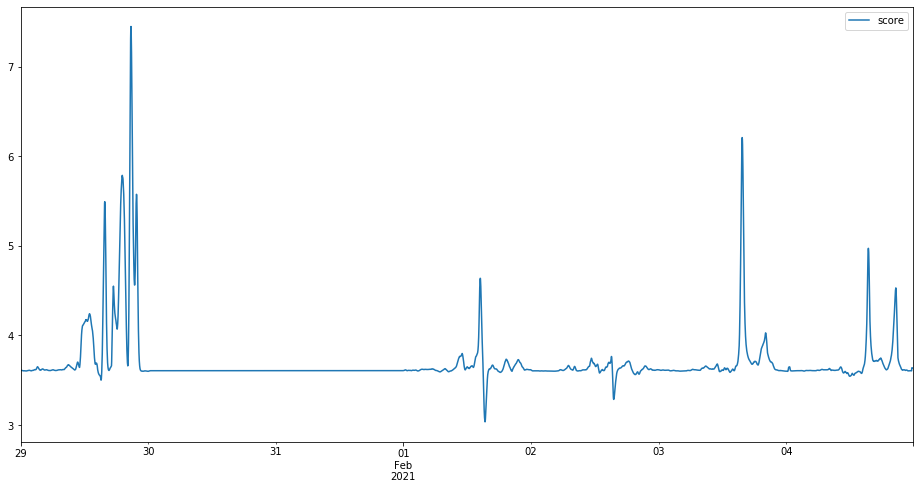

In [14]:

for t in time_index_weekdays:
    times = nona_weekdays[nona_weekdays['time_index']==t].index
    signals = generate_model_input(df_test_weekdays, ycols, times, params['weekdays']['period'], params['weekdays']['modnorms'], offset=t, median_values=params['weekdays']['profile'])
    _signals = signals.reshape([signals.shape[0], -1])

    _signals = torch.from_numpy(signals)
    signals = Variable(_signals.float())
    code,preds = ae_weekdays(signals)
    errors = np.sum(np.square((signals-preds).detach().numpy()), axis=1)
    test_seq_weekdays.loc[times, 'score'] = errors
    #logging.info(f"finished scoring window {t}")

#K.clear_session()

test_seq_weekdays[['score']].plot(figsize=[16,8])

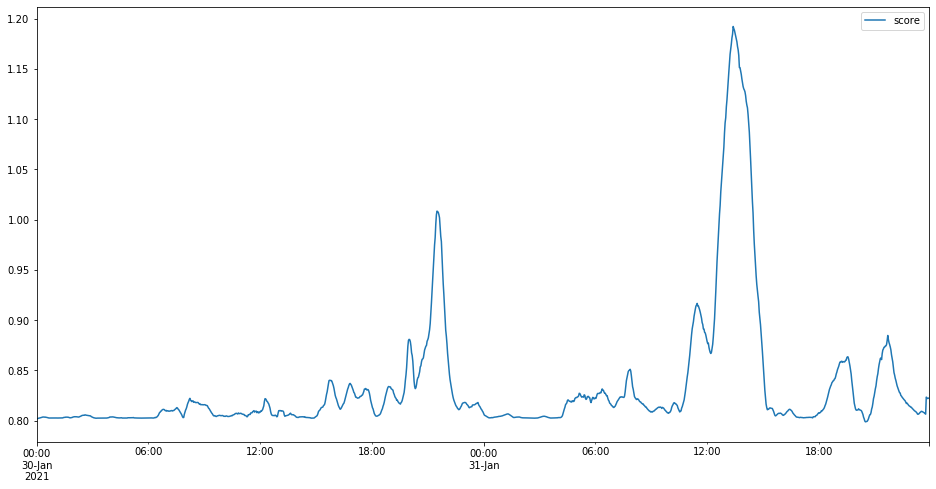

In [15]:
for t in time_index_weekends:
    times = nona_weekends[nona_weekends['time_index']==t].index
    signals = generate_model_input(df_test_weekends, ycols, times, params['weekends']['period'], params['weekends']['modnorms'], offset=t, median_values=params['weekends']['profile'])
    _signals = signals.reshape([signals.shape[0], -1])

    _signals = torch.from_numpy(signals)
    signals = Variable(_signals.float())
    code,preds = ae_weekends(signals)
    errors = np.sum(np.square((signals-preds).detach().numpy()), axis=1)
    test_seq_weekends.loc[times, 'score'] = errors
    #logging.info(f"finished scoring window {t}")

#K.clear_session()

test_seq_weekends[['score']].plot(figsize=[16,8])

In [3]:
from modeling.pytorch_ae import TrainPytorchAE
from preprocessing.preprocessor import LeftPad
from preprocessing.preprocessor import LoadData, FindFrequency, PeriodDetect, AlignData, DropExtrema, Normalizer, FillGap, GenerateInput
from pipeline import Pipeline

training_list = [
    LoadData(fname, dscol, ycols),
    FindFrequency(),
    PeriodDetect(),
    AlignData(),
    DropExtrema(),
    Normalizer(),
    FillGap(),
    GenerateInput(),
    TrainPytorchAE()
]
training_pipeline = Pipeline()
ae_list, params_t = training_pipeline.fit_transform(training_list)
test_seq_2 = training_pipeline.prediction('data/210129-210204_weekly.csv', ae_list, params_t)

Using TensorFlow backend.
/Users/preh0405/opt/anaconda3/envs/chrono/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/preh0405/opt/anaconda3/envs/chrono/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/preh0405/opt/anaconda3/envs/chrono/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

/Users/preh0405/Desktop/chrono+/notebook


Finding frequency:   0%|          | 0/2 [00:00<?, ?it/s]

(25200, 10)
(10080, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs'])
dict_keys(['minfreq', 'colfreqs'])


Detecting Period:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/preh0405/opt/anaconda3/envs/chrono/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


(25200, 10)
(10080, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period'])
dict_keys(['minfreq', 'colfreqs', 'period'])


Aligning data:   0%|          | 0/2 [00:00<?, ?it/s]

(35279, 10)
(31679, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint'])


Dropping Extrema:   0%|          | 0/2 [00:00<?, ?it/s]

(35279, 10)
(31679, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint'])


Normalising:   0%|          | 0/2 [00:00<?, ?it/s]

(35279, 11)
(31679, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms'])


Filling gap:   0%|          | 0/2 [00:00<?, ?it/s]

ok10
ok20
ok11
ok21
(35279, 11)
(31679, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
(35279, 11)
(31679, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


Generating Input:   0%|          | 0/2 [00:00<?, ?it/s]

epoch number:0 train_loss: 0.022769822739064693 val_loss: 0.007507673080661405
epoch number:0 train_loss: 0.02695130743086338 val_loss: 0.010862880702886029


Finding frequency:   0%|          | 0/2 [00:00<?, ?it/s]

(3600, 10)
(1440, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


Aligning data:   0%|          | 0/2 [00:00<?, ?it/s]

(5039, 10)
(1439, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


Normalising:   0%|          | 0/2 [00:00<?, ?it/s]

(5039, 11)
(1439, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


  0%|          | 0/2 [00:00<?, ?it/s]

(5758, 11)
(2158, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


Filling gap:   0%|          | 0/2 [00:00<?, ?it/s]

ok10
ok20
ok11
ok21
(5758, 11)
(2158, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


Finding frequency:   0%|          | 0/2 [00:00<?, ?it/s]

(3600, 10)
(1440, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


Aligning data:   0%|          | 0/2 [00:00<?, ?it/s]

(5039, 10)
(1439, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


Normalising:   0%|          | 0/2 [00:00<?, ?it/s]

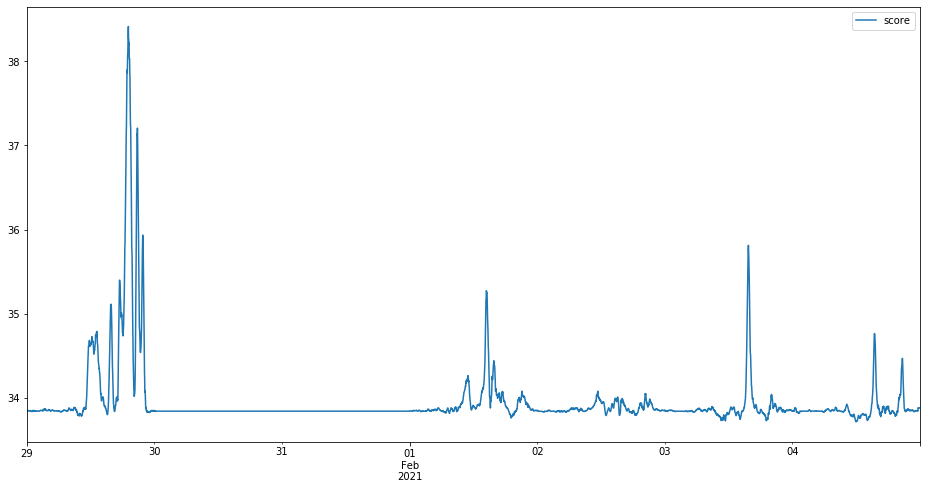

In [4]:
test_seq_2[0][['score']].plot(figsize=[16,8])

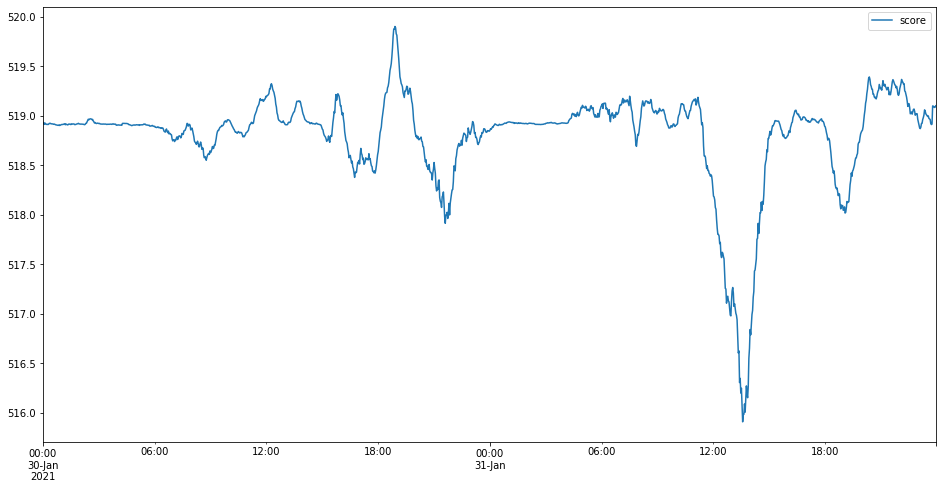

In [5]:
test_seq_2[1][['score']].plot(figsize=[16,8])

In [6]:
params = params_t

### Test on AE model ###

In [7]:
def leftpad(df, ycols, minfreq, period, profile):
    """leftpads dataframe by period-1 points with median values for each column"""
    df = df.copy()

    firstindex = df['time_index'][0]
    leftpad_index = [i%period for i in range(firstindex - (period - 1), firstindex)]
    dat = {y:[profile.loc[i][y] for i in leftpad_index] for y in ycols}
    dat['time_index'] = leftpad_index
    leftdf = pd.DataFrame(
        data = dat,
        index = pd.date_range(end=df.index[0], periods=period, freq=minfreq, closed='left'))
    df = leftdf.append(df)

    return df

In [8]:
from preprocessing.preprocessor import LeftPad
testinput1_list = [
    LoadData('data/210129-210204_weekly.csv', dscol, ycols, params),
    FindFrequency(),
    AlignData(),
    Normalizer(),
    LeftPad(),
    FillGap(),
] 
testinput1_pipeline = Pipeline()
dfs1_test, test1_params = testinput1_pipeline.transform(testinput1_list)
df_test_weekdays = dfs1_test[0]
df_test_weekends = dfs1_test[1]

Finding frequency:   0%|          | 0/2 [00:00<?, ?it/s]

(3600, 10)
(1440, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


Aligning data:   0%|          | 0/2 [00:00<?, ?it/s]

(5039, 10)
(1439, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


Normalising:   0%|          | 0/2 [00:00<?, ?it/s]

(5039, 11)
(1439, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


  0%|          | 0/2 [00:00<?, ?it/s]

(5758, 11)
(2158, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


Filling gap:   0%|          | 0/2 [00:00<?, ?it/s]

ok10
ok20
ok11
ok21
(5758, 11)
(2158, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


In [9]:
testinput2_list = [
    LoadData('data/210129-210204_weekly.csv', dscol, ycols, params),
    FindFrequency(),
    AlignData(),
    Normalizer(),
] 
testinput2_pipeline = Pipeline()
dfs2_test, test2_params = testinput2_pipeline.transform(testinput2_list)
test_seq_weekdays = dfs2_test[0]
test_seq_weekends = dfs2_test[1]
nona_weekdays = test_seq_weekdays.dropna(how="all")
nona_weekends = test_seq_weekends.dropna(how="all")
time_index_weekdays = params['weekdays']['time_index']
time_index_weekends = params['weekends']['time_index']

Finding frequency:   0%|          | 0/2 [00:00<?, ?it/s]

(3600, 10)
(1440, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


Aligning data:   0%|          | 0/2 [00:00<?, ?it/s]

(5039, 10)
(1439, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


Normalising:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
print(params['weekdays']['zeropoint'])

2021-02-05 00:00:00


In [11]:
# scorefname = 'data/210129-210204_weekly.csv' # substitute to score different data
# df_test_weekdays, df_test_weekends = ingest(scorefname, dscol, ycols)

# df_test_weekdays, _, _ = ae_preproc(df_test_weekdays, ycols)
# original_data = df_test_weekdays.copy() # saved because we might need it later

# aligned_weekdays, _, _ = align_data(original_data, colfreqs_weekdays, minfreq_weekdays, anchors_weekdays, zeropoint_weekdays)
# aligned_weekdays['time_index'] = [((t-zeropoint_weekdays)//minfreq_weekdays)%period_weekdays for t in aligned_weekdays.index]
# df_test_weekdays = leftpad(aligned_weekdays, ycols, minfreq_weekdays, period_weekdays, median_profiles_weekdays)
# df_test_weekdays = fill_gaps(df_test_weekdays, colfreqs_weekdays, minfreq_weekdays, period_weekdays, median_profiles_weekdays, zeropoint_weekdays)
# test_seq_weekdays = aligned_weekdays.copy()
# nona_weekdays = test_seq_weekdays.dropna(how="all")

# df_test_weekends, _, _ = ae_preproc(df_test_weekends, ycols)
# original_data_weekends = df_test_weekends.copy() # saved because we might need it later

# aligned_weekends, _, _ = align_data(original_data_weekends, colfreqs_weekends, minfreq_weekends, anchors_weekends, zeropoint_weekends)
# aligned_weekends['time_index'] = [((t-zeropoint_weekends)//minfreq_weekends)%period_weekends for t in aligned_weekends.index]
# df_test_weekends = leftpad(aligned_weekends, ycols, minfreq_weekends, period_weekends, median_profiles_weekends)
# df_test_weekends = fill_gaps(df_test_weekends, colfreqs_weekends, minfreq_weekends, period_weekends, median_profiles_weekends, zeropoint_weekends)
# test_seq_weekends = aligned_weekends.copy()
# nona_weekends = test_seq_weekends.dropna(how="all")

In [12]:
def normdf(df, modnorms):
    normed = df.copy()
    for y, ( ymin, ymax ) in modnorms.items():
        mmdiff = ymax - ymin
        normed[y] = (normed[y]-ymin)/mmdiff
    return normed

def generate_model_input(df, ycols, times, period, modnorms, offset=None, median_values=None):
    """
generate model input for windows ending at timestamps in the times arguments

Assumptions:
    1. times all have the same time index relative to period
    2. sampling intervals for each column are regular
    """
    offset = period-1 if offset is None else offset
    window_size = 10
    rows = []
    for t in times:
        idx = df.index.get_loc(t)+1
        rowdf = df.iloc[idx-period:idx].copy()
        if median_values is not None and window_size<period:
            replaceidx = rowdf.iloc[:len(rowdf)-window_size].index
            rowdf.loc[replaceidx, ycols] = median_values.loc[rowdf.loc[replaceidx, "time_index"], ycols].to_numpy()
        # normalize training/scoring data
        rowdf = normdf(rowdf, modnorms)
        startpos = period-1-offset
        rowdf = rowdf.iloc[startpos:].append(rowdf.iloc[:startpos])  # [ANDY] why?
        row = np.concatenate([rowdf[y].dropna() for y in ycols])
        rows.append(row)

    collens = set(len(r) for r in rows)
    if len(collens)!=1:
        logging.error(f"detected row lengths: {collens}")
        raise MisalignedColumnsError("unable to create input data because dimensions don't match")

    numcols = collens.pop()

    return np.concatenate(rows).reshape(( -1, numcols ))

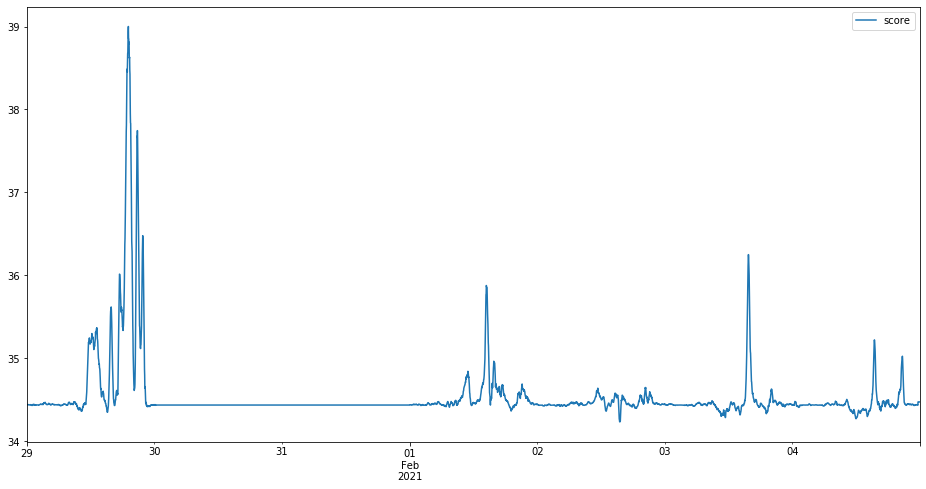

In [13]:

for t in time_index_weekdays:
    times = nona_weekdays[nona_weekdays['time_index']==t].index
    signals = generate_model_input(df_test_weekdays, ycols, times, params['weekdays']['period'], params['weekdays']['modnorms'], offset=t, median_values=params['weekdays']['profile'])
    _signals = signals.reshape([signals.shape[0], -1])

    _signals = torch.from_numpy(signals)
    signals = Variable(_signals.float())
    code,preds = ae_list[0](signals)
    errors = np.sum(np.square((signals-preds).detach().numpy()), axis=1)
    test_seq_weekdays.loc[times, 'score'] = errors
    #logging.info(f"finished scoring window {t}")

#K.clear_session()

test_seq_weekdays[['score']].plot(figsize=[16,8])

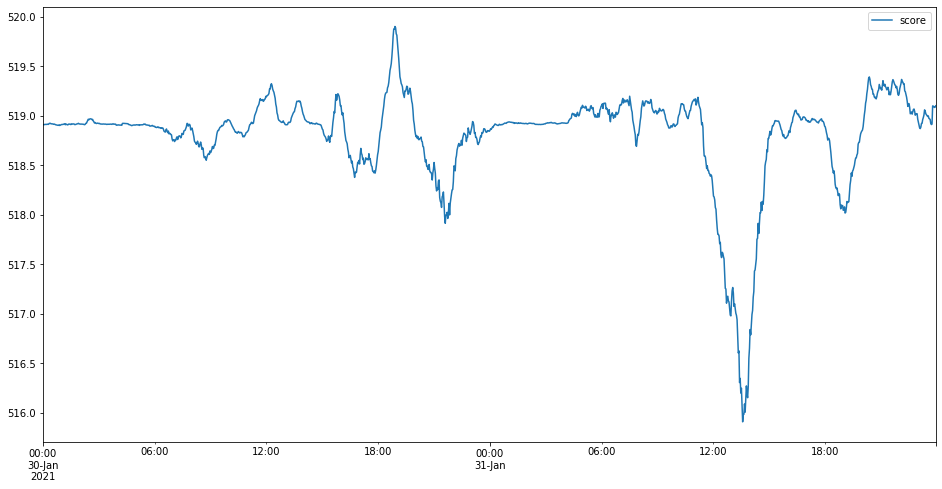

In [14]:
for t in time_index_weekends:
    times = nona_weekends[nona_weekends['time_index']==t].index
    signals = generate_model_input(df_test_weekends, ycols, times, params['weekends']['period'], params['weekends']['modnorms'], offset=t, median_values=params['weekends']['profile'])
    _signals = signals.reshape([signals.shape[0], -1])

    _signals = torch.from_numpy(signals)
    signals = Variable(_signals.float())
    code,preds = ae_list[1](signals)
    errors = np.sum(np.square((signals-preds).detach().numpy()), axis=1)
    test_seq_weekends.loc[times, 'score'] = errors
    #logging.info(f"finished scoring window {t}")

#K.clear_session()

test_seq_weekends[['score']].plot(figsize=[16,8])